# <span style="color:blue">  Movie Tweetings PySpark Recommender</span>


From the November 27th tweetings avaliable, the ratings and items data files will be loaded first into pandas and then converted to Spark dataframes. Both versions will be used for analysis and visualization purposes. 



In [1]:
import findspark
findspark.init('/usr/local/opt/apache-spark/libexec')
from pyspark import SparkContext
import pyspark
import pandas as pd

sc = pyspark.SparkContext(appName="spark based notebook")

#print sc


In [2]:
pdmovies = pd.read_csv('movies.dat', sep='::', header='infer', skipinitialspace=True,names = ["MovieId","Movie_Title","Genres"])
pdmovies = pdmovies.drop('Genres', 1)
pdmovies[['movie', 'year']] = pdmovies['Movie_Title'].str.split('(',expand=True)
pdmovies[['year', 'del']] = pdmovies['year'].str.split(')',expand=True)
pdmovies = pdmovies.drop('del', 1)
pdmovies = pdmovies.drop('Movie_Title', 1)
pdratings = pd.read_csv('ratings.dat', sep='::', header='infer', skipinitialspace=True,names = ["UserId", "MovieId", "Rating", "Timestamp"])
pdratings=pdratings.drop('Timestamp',1)

/Users/B.Patel@ibm.com/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/Users/B.Patel@ibm.com/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


In [3]:
import numpy as np
pdratings=pdratings.merge(pdmovies,on='MovieId',how='left')
pdratings["scaled"] = np.sign(pdratings.Rating - 5)
#print(pdratings)

The pandas dataframes are now converted to Spark dataframes using SQL Context.

In [4]:
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)
ratings=sqlCtx.createDataFrame(pdratings)


# Exploratory Analysis & Visualization of Data

In [5]:
ratings.describe().show()

+-------+------------------+------------------+-----------------+---------+------------------+------------------+
|summary|            UserId|           MovieId|           Rating|    movie|              year|            scaled|
+-------+------------------+------------------+-----------------+---------+------------------+------------------+
|  count|            661041|            661041|           661041|   661041|            661041|            661041|
|   mean|25746.769123246515|1682644.1942859823|7.301606103101018| Infinity|2008.3000766972093|0.7817381977819833|
| stddev|14790.731994397118| 1261723.933614962|1.861220224723241|      NaN|12.648961199287482|0.5618353337379685|
|    min|                 1|                 8|                0|       $ |              1878|                -1|
|    max|             51713|           7659376|               10|Ãrestir |              2017|                 1|
+-------+------------------+------------------+-----------------+---------+-------------

In [6]:


print "Number of different users: " + str(ratings.select('userId').distinct().count())
print "Number of different movies: " + str(ratings.select('movieId').distinct().count())
print "Number of movies with at least one rating strictly less than 5: " + str(ratings.filter('rating < 5').select('movieId').distinct().count())
print "Number of movies with at least one rating 5 or greater : " + str(ratings.filter('rating >= 5').select('movieId').distinct().count())



Number of different users: 51713
Number of different movies: 29733
Number of movies with at least one rating strictly less than 5: 10230
Number of movies with at least one rating 5 or greater : 27234


In particular, we lack here a substantial number of ratings for items that are disliked by our users. This intuitively makes sense. Users may prefer to share their movie rating through Twitter if they enjoyed watching the film to allow their followers to know about a great movie. 


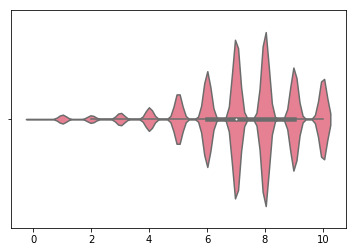

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.violinplot([pdratings.Rating],palette="husl")

We see here again that users tend to tweet structured tweets about movies they rate highly.

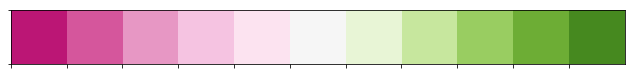

In [8]:
sns.palplot(sns.color_palette("PiYG", 11))


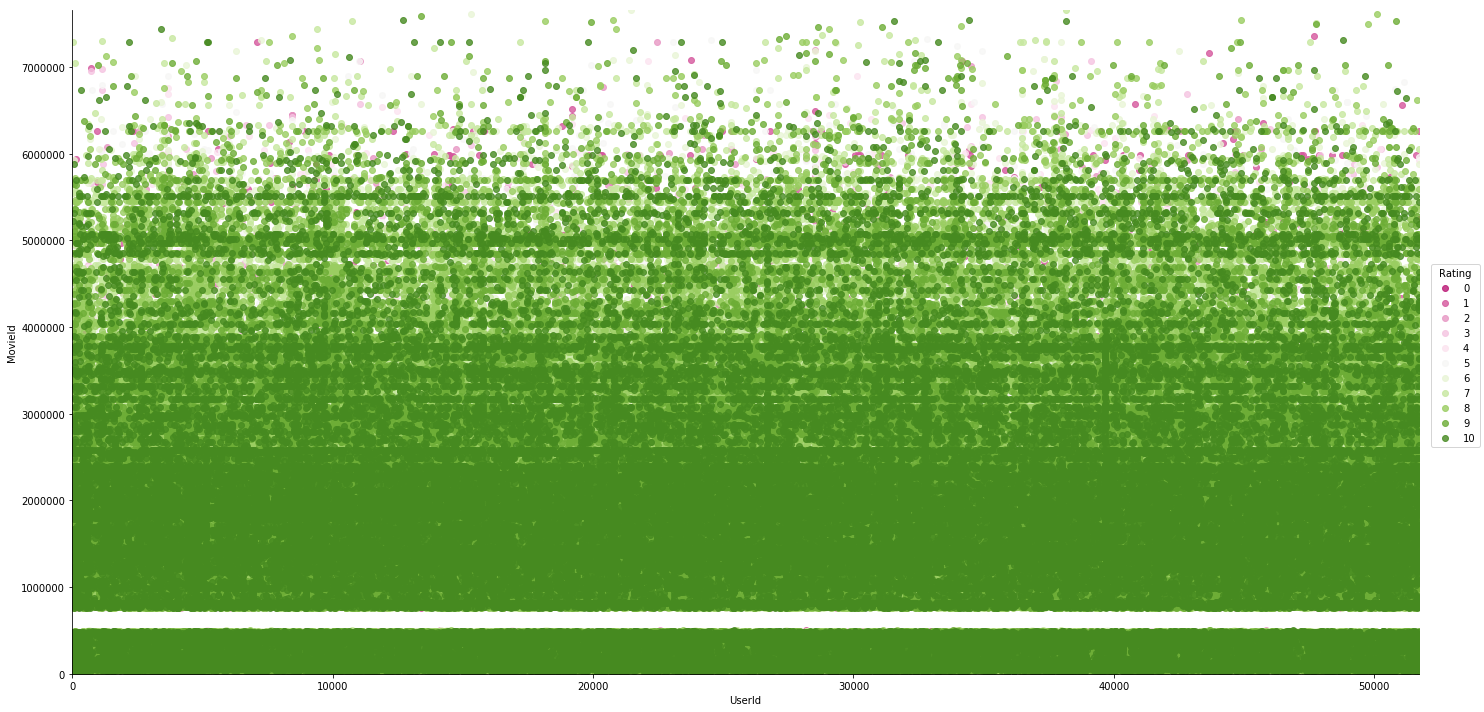

In [9]:


visualize = sns.lmplot(x='UserId', y='MovieId', hue='Rating', data=pdratings, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

# <span style="color:#3498db">  Implicit Feedback Model v Explicit Ratings Model</span>

Assuming that the asymmetric nature of the ratings distribution arises because of an analog of voluntary response bias, or rather in this case voluntary tweet bias, we can test the ALS model when ratings are considered as an explicit rating versus whether this provides implicit feedback representing strength of opinion. 

# Implicit Feedback Model

The data is initially split into 80% training data and 20% test data. 

In [10]:
from pyspark.ml.recommendation import ALS
(trainingRatings, testRatings) = ratings.randomSplit([80.0, 20.0])
als = ALS(userCol="UserId", itemCol="MovieId", ratingCol="Rating",implicitPrefs=True,coldStartStrategy="drop")

ALSimplmodel = als.fit(trainingRatings)

In [11]:
imppredictions = ALSimplmodel.transform(testRatings)
imppredictions.show()

+------+-------+------+--------------------+----+------+------------+
|UserId|MovieId|Rating|               movie|year|scaled|  prediction|
+------+-------+------+--------------------+----+------+------------+
|  9574|  18051|     9|    The Kid Brother |1927|     1| 0.020883908|
| 11470|  46521|     8|        I vitelloni |1953|     1|   0.1741872|
| 32098|  46521|     8|        I vitelloni |1953|     1|   0.1682909|
| 15728|  48254|     9|      Killer's Kiss |1955|     1|  0.06408443|
|   416|  64519|    10|      DoppelgÃ¤nger |1969|     1| 0.017461734|
| 23799|  70355|     9|       Magnum Force |1973|     1| 0.011771623|
| 15453|  70355|     7|       Magnum Force |1973|     1| 0.031488247|
| 41027|  70355|     7|       Magnum Force |1973|     1| 0.008456899|
|  7085|  70355|     5|       Magnum Force |1973|     0|0.0050403536|
| 10816|  72820|     8|        Cooley High |1975|     1| 0.014924954|
| 11185|  74281|     7|           Car Wash |1976|     1|0.0017723457|
|  9062|  85253|    

In [12]:
imp=imppredictions.toPandas()
imp=imp.sort_values(by=['UserId', 'prediction'],ascending=False)

In [13]:
implicit_by_pred=imp.groupby('UserId').head(3).reset_index(drop=True)

In [14]:
test=testRatings.toPandas()
test=test.sort_values(by=['UserId', 'Rating'],ascending=False)
test=test.groupby('UserId').head(3).reset_index(drop=True)

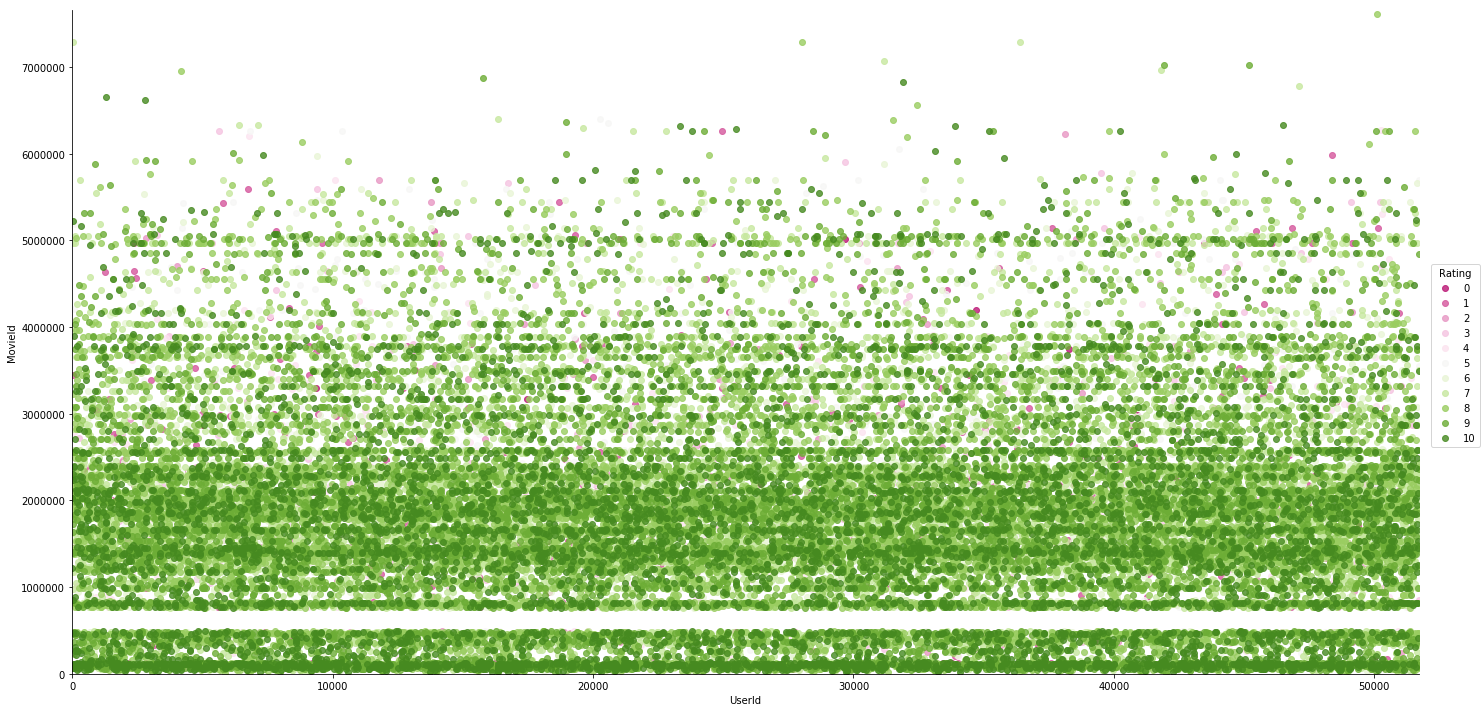

In [15]:
visualize = sns.lmplot(x='UserId', y='MovieId', hue='Rating', data=implicit_by_pred, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

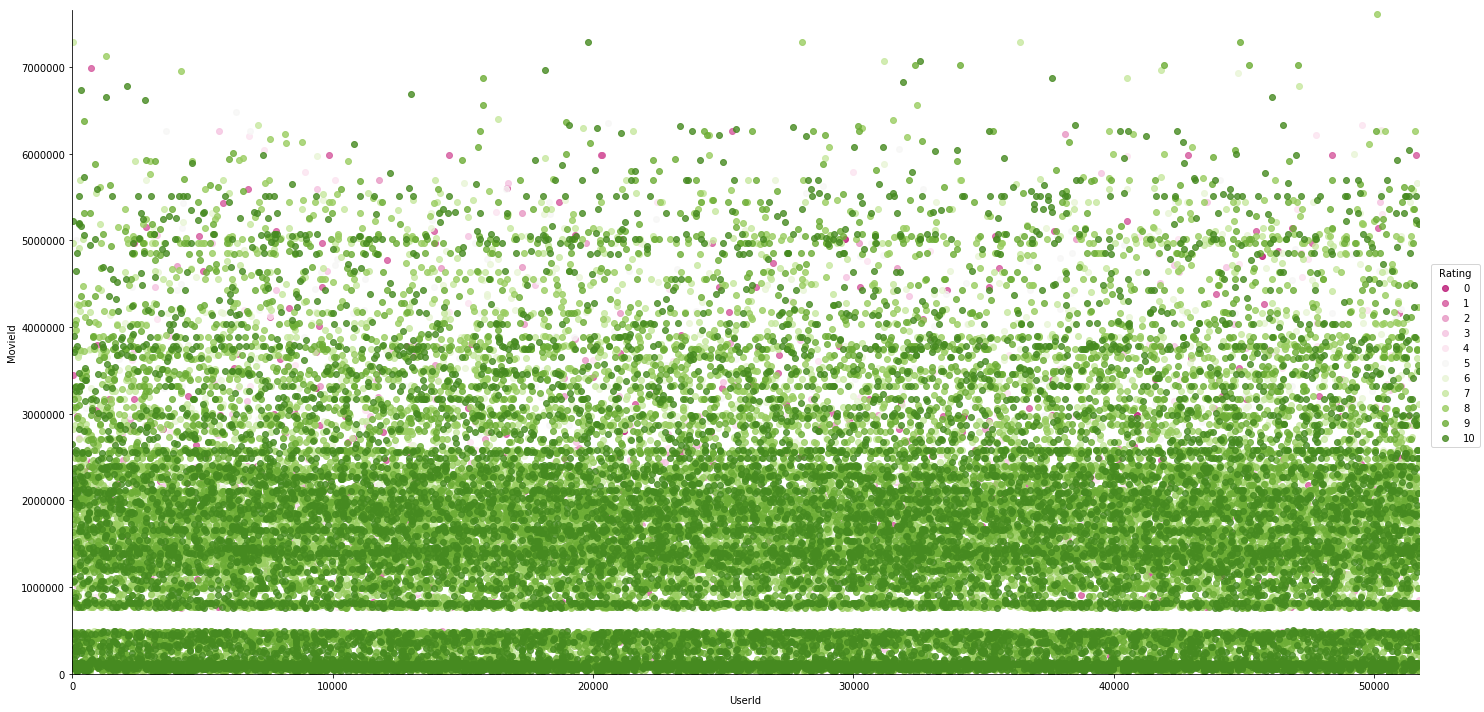

In [16]:
visualize = sns.lmplot(x='UserId', y='MovieId',hue='Rating', data=test, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

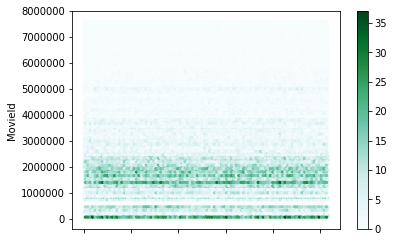

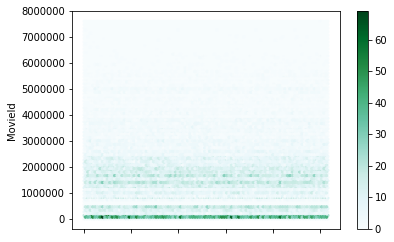

In [17]:
import numpy as np
import pylab as plt

#plt.scatter(UserId,MovieId,data=implicit_by_rating,color='k')
#plt.scatter(X,Y2,color='g')
#plt.show()

implicit_by_pred.plot(kind='hexbin', x='UserId', y='MovieId')
test.plot(kind='hexbin', x='UserId', y='MovieId')

The graphs above show that this implicit feedback model has given prediction value that correspond to the true top k=3 movies that individuals have rated and subsequently tweeted about. Spark does not have a metric calculator for precision and recall for such a model. Therefore, we will continue to now exploring the explicit ratings model.

# Explicit Ratings Model

In [18]:

(trainingRatings, testRatings) = ratings.randomSplit([90.0, 10.0])
als = ALS(userCol="UserId", itemCol="MovieId", ratingCol="Rating")
ALSmodel = als.fit(trainingRatings)

In [19]:
predictions = ALSmodel.transform(testRatings)
predictions.show()

+------+-------+------+--------------------+----+------+----------+
|UserId|MovieId|Rating|               movie|year|scaled|prediction|
+------+-------+------+--------------------+----+------+----------+
| 37593|   4101|    10| His New Profession |1914|     1|       NaN|
|  4893|  46521|    10|        I vitelloni |1953|     1| 7.5694995|
| 32098|  46521|     8|        I vitelloni |1953|     1| 7.5972223|
|  7783|  46521|     8|        I vitelloni |1953|     1|  8.825398|
| 32397|  64519|     4|      DoppelgÃ¤nger |1969|    -1| 6.0255833|
| 41027|  70355|     7|       Magnum Force |1973|     1|  7.797452|
| 37964|  72820|     4|        Cooley High |1975|    -1| 7.2710767|
| 11185|  74281|     7|           Car Wash |1976|     1|  7.522517|
| 14701|  86927|     7|     Bachelor Party |1984|     1| 7.5080576|
| 51190|  92644|     7|Beverly Hills Cop...|1987|     1| 7.2129335|
| 14376|  92644|     8|Beverly Hills Cop...|1987|     1| 7.9708214|
| 25500|  92644|     8|Beverly Hills Cop...|1987

In [20]:
exp=predictions.toPandas()
exp=exp.sort_values(by=['UserId', 'prediction'],ascending=False)
explicit_by_pred=exp.groupby('UserId').head(3).reset_index(drop=True)

In [21]:
exp=exp.sort_values(by=['UserId', 'Rating'],ascending=False)
explicit_by_rating=exp.groupby('UserId').head(3).reset_index(drop=True)

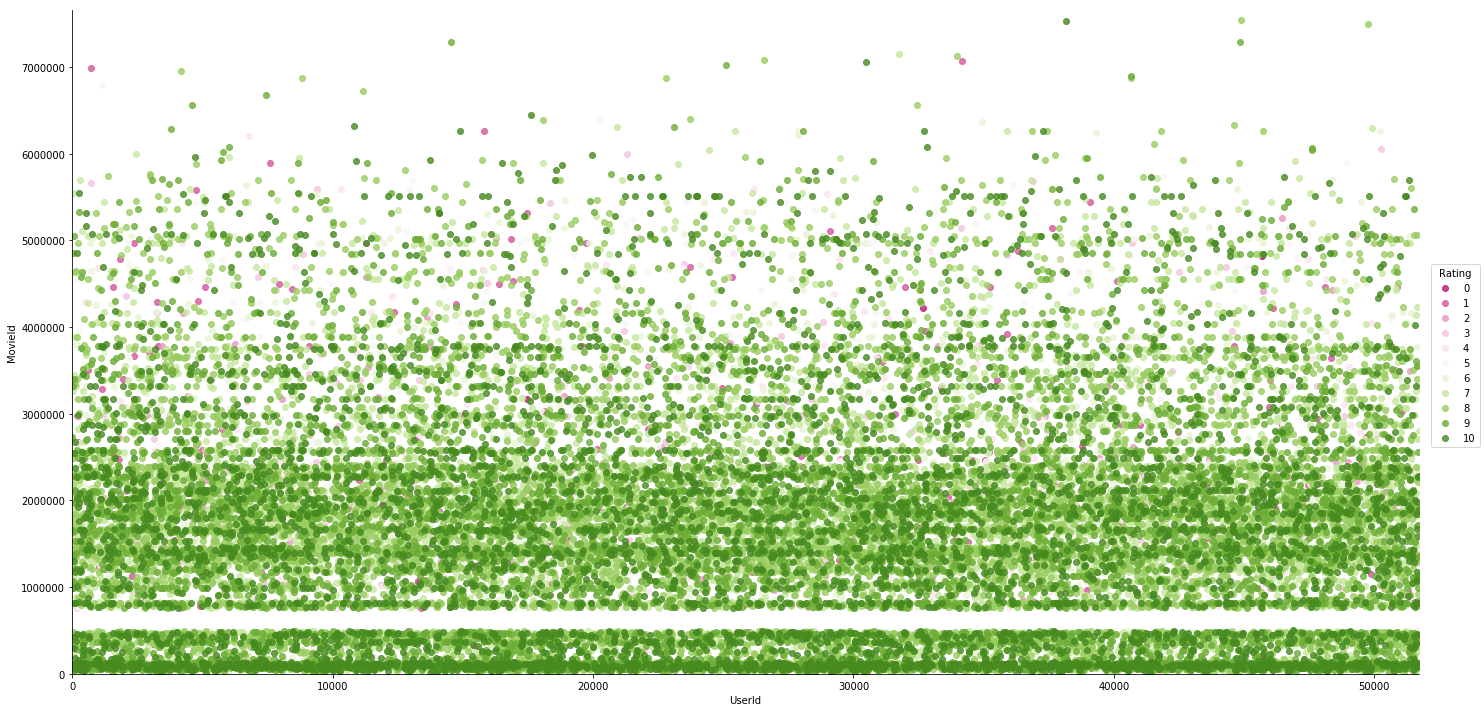

In [22]:
visualize = sns.lmplot(x='UserId', y='MovieId', hue='Rating', data=explicit_by_pred, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

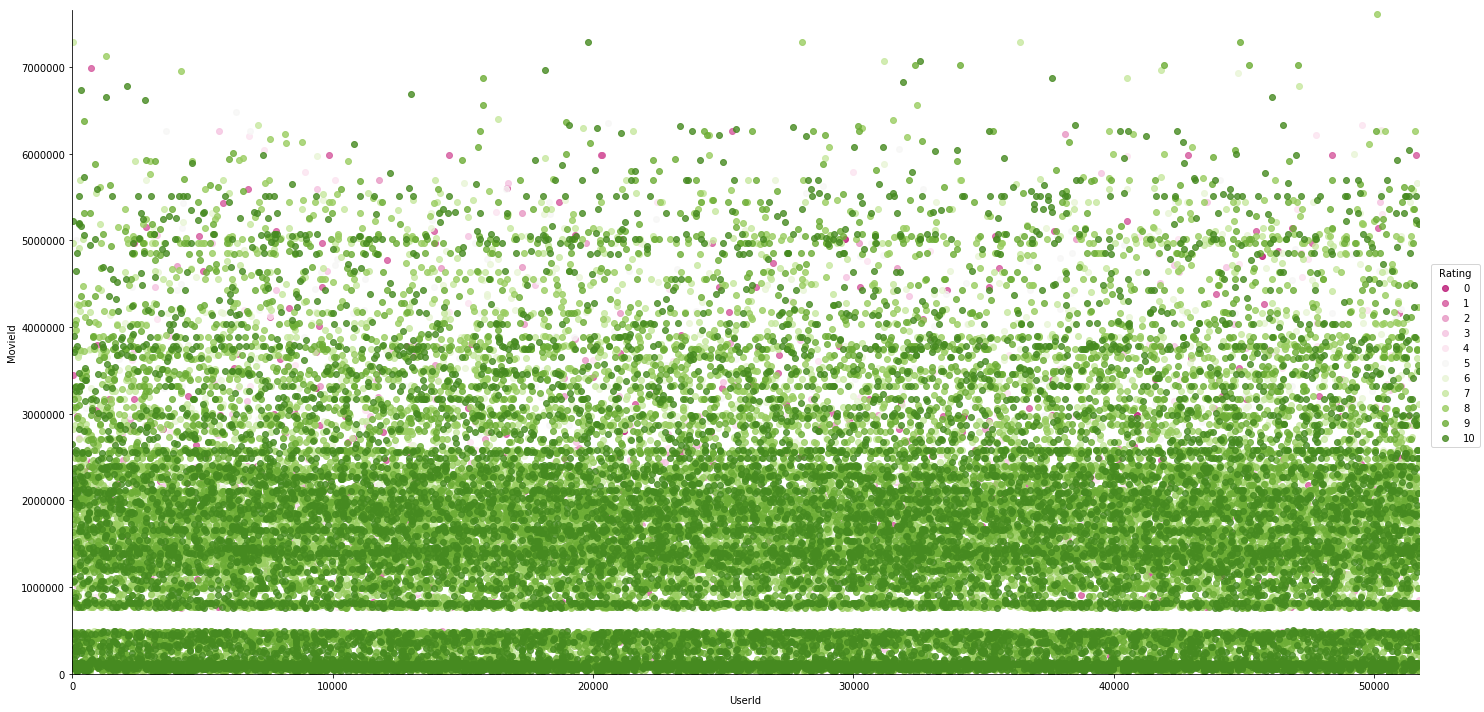

In [23]:
visualize = sns.lmplot(x='UserId', y='MovieId',hue='Rating', data=test, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

Now we will compare the model with a naive baseline that always returns the mean rating through RMSE.

In [24]:
test=testRatings.toPandas()
test['mean'] = test["Rating"].mean()
test['difference']=(test['Rating']-test['mean'])
test['difference']=test['difference']**2


In [25]:
baselinermse=test["difference"].mean()**.5
baselinermse

1.7016990643335757

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
print "The root mean squared error for the model is: " + str(evaluator.evaluate(predictions))

The root mean squared error for the model is: nan


NaN results because the ALS model cannot predict ratings for users who have no ratings which is also known as the Cold Start problem. In this business case scenario we would still wish to predict recommendations for that user. Therefore, we elect to replace NaN values with the average rating and evaluate the model.

In [27]:
average = ratings.select('rating').groupBy().avg().first()[0]
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
testRMSE=(evaluator.evaluate(predictions.na.fill(average))) 
print "The root mean squared error for the model is: " + str(evaluator.evaluate(predictions.na.fill(average))) 


The root mean squared error for the model is: 1.66351300343


In [28]:
improvement = (baselinermse - testRMSE) / baselinermse * 100
improvement

2.2439961155704617

There is only a modest ~ 2% improvement over the naive model that rates every movie the average of movie ratings.  

# Tuning Hyperparamters for Explicit Ratings Model: Rank & the Regularization Parameter

The following hyperparamter modeling is computationally costly. A grid of parameter combinations is created a grid search is run over these respective combinations to compare their performance. The resulting model has an RMSE that is greater than the model above. 
Note: Because this is computationally costly, it may take several minutes to run.

In [37]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(trainingRatings, validationRatings) = ratings.randomSplit([90.0, 10.0])
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")

paramGrid = ParamGridBuilder()\
            .addGrid(als.rank, [5, 10])\
            .addGrid(als.maxIter, [10])\
            .addGrid(als.regParam, [.01,0.05, 0.1, 0.5])\
            .build()

crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
cvModel = crossval.fit(trainingRatings)
predictions = cvModel.transform(validationRatings)

print "The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.fill(average)))

The root mean squared error for our model is: 2.154831789


The RMSE here is greater than that of the default ALS model: rank=10, maxIter=10, regParam=0.1. 

# Recommending New Movies

Our business seeks to drive its revenue growth by partnering with cinemas and theaters and providing new movie recommendations. We want to constrain the movies recommendations to those that have just hit the screens recently. We will therefore give the top recommendations for those movies that have been released within the last 2 years, capturing the market of theaters that stream movies for $2 that are between the box office and blu-ray avaliability as well as traditional theaters. For users where such a movie recommendation is not possible, we will recommend the most recent movies possible for them. 

The approach we undertake is essentially augmenting or constraining the explicit ratings model and only recommeding the top n=3 most recent movies. We will then check the perfomance of this model versus if we used a naive baseline that always returns the mean rating.

In [41]:
exp=exp.sort_values(by=['UserId', 'year', 'prediction'],ascending=False)


In [43]:
newmovies=exp.groupby('UserId').head(3).reset_index(drop=True)

In [48]:
newmovies['mean'] = newmovies["prediction"].mean()
newmovies['difference']=(newmovies['Rating']-newmovies['mean'])
newmovies['difference']=newmovies['difference']**2


UserId  MovieId  Rating                                 movie  year  \
0       51711  3315342       7                                Logan   2017   
1       51711  3450958       5       War for the Planet of the Apes   2017   
2       51711  2568862       6                       Going in Style   2017   
3       51709   451279      10                         Wonder Woman   2017   
4       51709  2250912       6               Spider-Man: Homecoming   2017   
5       51709  2277860      10                         Finding Dory   2016   
6       51706   278504       7                             Insomnia   2002   
7       51704  2709768       7              The Secret Life of Pets   2016   
8       51704  1895587      10                            Spotlight   2015   
9       51699  1136608       9                           District 9   2009   
10      51699   417148       7                    Snakes on a Plane   2006   
11      51696  1333125       7                             Movie 43   2013   
12      51693   993846       9              The Wolf of Wall Street   2013   
13      51690  1843866       8  Captain America: The Winter Soldier   2014   
14      51690  1483013       7                             Oblivion   2013   
15      51690   844286       9                   The Brothers Bloom   2008   
16      51686   816692      10                         Interstellar   2014   
17      51685  1840309       8                            Divergent   2014   
18      51685  2278388       9             The Grand Budapest Hotel   2014   
19      51682  2217859       8                    Louder Than Bombs   2015   
20      51681    91954       8                        Sid and Nancy   1986   
21      51676  2709768       7              The Secret Life of Pets   2016   
22      51675  2562232       9                              Birdman   2014   
23      51675  1291150       1         Teenage Mutant Ninja Turtles   2014   
24      51675   120689      10                       The Green Mile   1999   
25      51668  1714206       9                  The Spectacular Now   2013   
26      51667  2267998      10                            Gone Girl   2014   
27      51667  1972571       7                    A Most Wanted Man   2014   
28      51667  2370248       7                        Short Term 12   2013   
29      51666  5074352       5                               Dangal   2016   
...       ...      ...     ...                                   ...   ...   
32590      55  1613750       5                             Kon-Tiki   2012   
32591      54  4034228       8                Manchester by the Sea   2016   
32592      54  1663202       9                         The Revenant   2015   
32593      54  3170832       5                                 Room   2015   
32594      51  1661199       8                           Cinderella   2015   
32595      51  1343092       7                     The Great Gatsby   2013   
32596      51  2083383       8               Trouble with the Curve   2012   
32597      45  3263904       7                                Sully   2016   
32598      44  1034314       4                             Iron Sky   2012   
32599      44  1232829       7                       21 Jump Street   2012   
32600      44  1270291       3                          Hunter Prey   2010   
32601      42  1853739       2                          You're Next   2011   
32602      39  1631867       9                     Edge of Tomorrow   2014   
32603      37  2488496       8         Star Wars: The Force Awakens   2015   
32604      34  1074638       9                              Skyfall   2012   
32605      32  2194499       8                           About Time   2013   
32606      32  1300854       6                           Iron Man 3   2013   
32607      32  1763303       7                       The First Time   2012   
32608      31  3315342       9                                Logan   2017   
32609      31  5541240       

In [49]:
newmoviesrmse=newmovies["difference"].mean()**.5
newmoviesrmse

1.9235182136187023

Now we will compare this to the naive model that will return the top 3 newest movies recommended for a user

In [70]:
test=testRatings.toPandas()

In [71]:
test['mean'] = test["Rating"].mean()
test=test.sort_values(by=['UserId', 'year', 'mean'],ascending=False)
test=test.groupby('UserId').head(3).reset_index(drop=True)
test['difference']=(test['Rating']-test['mean'])
test['difference']=test['difference']**2


In [72]:
test['difference']=(newmovies['Rating']-newmovies['mean'])
test['difference']=newmovies['difference']**2


In [73]:
baselinermse=test["difference"].mean()**.5
baselinermse

6.8375554690253075

In [74]:
improvement = (baselinermse - newmoviesrmse) / baselinermse * 100
improvement

71.86833478232974

There is a roughly 3 fold improvement when predicting the top 3 new movies for a user with the explicit model versus the naive model. Intutively this makes sense, because the naive model will simply recommend the newest movies where the explicit rating model will consider the user's previous ratings. 